<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/facial_emotion_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing Libraries***

In [2]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import gc
from sklearn.utils import shuffle
import cv2 as cv
import skimage.io as skio

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
np_config.enable_numpy_behavior()
from PIL import Image
import cv2

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [3]:
labels = ['happy', 'sad', 'fear', 'angry', 'neutral', 'surprise', 'disgust']
label_dict = {'happy' : 1, 'sad' : 2, 'fear' : 3, 'angry' : 4, 'neutral' : 5, 'surprise' : 6, 'disgust' : 7}

# ***Support Functionalities***

## ***a. Defining Parmeters***

In [4]:
current_working_dir = '/content/gdrive/MyDrive' #os.getcwd()
image_file_extension = '.jpg'
train_path = 'fdtct_train'
test_path = 'fdtct_test'
validation_path = 'fdtct_validation'

happy_path = 'happy'
sad_path = 'sad'
disgust_path = 'disgust'
angry_path = 'angry'
surprise_path = 'surprise'
fear_path = 'fear'
neutral_path = 'neutral'

batch_size = 100
image_shape = 48

## ***b. Defining Functions***

In [5]:
def get_file_names(dir, image_file_extension = 'jpg'):
    """
    This function lists all the files in the directory.
    """
    return glob.glob(dir + '/*.'+ image_file_extension)

In [6]:
def read_image_file_in_np_array(image_file_name_list):
    """
    This function reads each image file in a Numpy array and returns it.
    """
    return np.asarray([cv2.imread(image_file) for image_file in image_file_name_list])

In [7]:
def convert_np_array_to_tensor(np_image_array):
    """
    This function converts the numpy array representation of each image in tensor.
    """
    return tf.convert_to_tensor(np_image_array, dtype = tf.float32)

In [8]:
def create_label(array_length, val):
    """
    This function creates array of the given value
    """
    label_np = np.empty(array_length); label_np.fill(val)
    return label_np

In [9]:
def convert_to_grayscale(tf_image_list):
    """
    This function converts color image to grayscale.
    """
    return tf.image.rgb_to_grayscale(tf_image_list) / 255.0

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# ***Obtaining File Information***

## ***a. Train Files***

In [11]:
train_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, happy_path))
train_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, sad_path))
train_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, angry_path))
train_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, surprise_path))
train_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, fear_path))
train_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, neutral_path))
train_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, disgust_path))

In [12]:
print(f"Number of train happy files: {len(train_happy_file_list)}")
print(f"Number of train sad files: {len(train_sad_file_list)}")
print(f"Number of train angry files: {len(train_angry_file_list)}")
print(f"Number of train neutral files: {len(train_neutral_file_list)}")
print(f"Number of train disgust files: {len(train_disgust_file_list)}")
print(f"Number of train fear files: {len(train_fear_file_list)}")
print(f"Number of train surprise files: {len(train_surprise_file_list)}")

Number of train happy files: 350
Number of train sad files: 350
Number of train angry files: 350
Number of train neutral files: 350
Number of train disgust files: 350
Number of train fear files: 350
Number of train surprise files: 350


## ***b. Test Files***

In [13]:
test_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, happy_path))
test_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, sad_path))
test_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, angry_path))
test_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, surprise_path))
test_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, fear_path))
test_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, neutral_path))
test_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, disgust_path))

In [14]:
print(f"Number of test happy files: {len(test_happy_file_list)}")
print(f"Number of test sad files: {len(test_sad_file_list)}")
print(f"Number of test angry files: {len(test_angry_file_list)}")
print(f"Number of test neutral files: {len(test_neutral_file_list)}")
print(f"Number of test disgust files: {len(test_disgust_file_list)}")
print(f"Number of test fear files: {len(test_fear_file_list)}")
print(f"Number of test surprise files: {len(test_surprise_file_list)}")

Number of test happy files: 112
Number of test sad files: 112
Number of test angry files: 112
Number of test neutral files: 112
Number of test disgust files: 111
Number of test fear files: 112
Number of test surprise files: 112


## ***c. Validation Files***

In [15]:
validation_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, happy_path))
validation_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, sad_path))
validation_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, angry_path))
validation_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, surprise_path))
validation_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, fear_path))
validation_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, neutral_path))
validation_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, disgust_path))

In [16]:
print(f"Number of validation happy files: {len(validation_happy_file_list)}")
print(f"Number of validation sad files: {len(validation_sad_file_list)}")
print(f"Number of validation angry files: {len(validation_angry_file_list)}")
print(f"Number of validation neutral files: {len(validation_neutral_file_list)}")
print(f"Number of validation disgust files: {len(validation_disgust_file_list)}")
print(f"Number of validation fear files: {len(validation_fear_file_list)}")
print(f"Number of validation surprise files: {len(validation_surprise_file_list)}")

Number of validation happy files: 87
Number of validation sad files: 87
Number of validation angry files: 87
Number of validation neutral files: 87
Number of validation disgust files: 87
Number of validation fear files: 87
Number of validation surprise files: 87


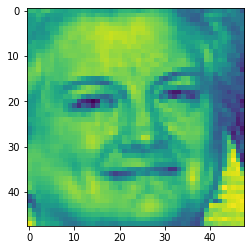

In [17]:
import matplotlib.pyplot as plt
image = plt.imread(os.path.join(current_working_dir, validation_path, happy_path) + '/100.jpg')
plt.imshow(image)

In [18]:
# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(os.path.join(current_working_dir, train_path),
                                                    target_size=(image_shape,image_shape),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(os.path.join(current_working_dir, validation_path),
                                                    target_size=(image_shape,image_shape),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

test_generator = datagen_validation.flow_from_directory(os.path.join(current_working_dir, test_path),
                                                    target_size=(image_shape,image_shape),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 2450 images belonging to 7 classes.
Found 609 images belonging to 7 classes.


In [ ]:
# Initialising the CNN
model4 = Sequential()

# 1 - Convolution
model4.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

# 2nd Convolution layer
model4.add(Conv2D(128,(5,5), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

# 3rd Convolution layer
model4.add(Conv2D(512,(3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

# 4th Convolution layer
model4.add(Conv2D(512,(3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

# Flattening
model4.add(Flatten())

# Fully connected layer 1st layer
model4.add(Dense(256))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.25))

# Fully connected layer 2nd layer
model4.add(Dense(512))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.25))

model4.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0001)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history4 = model4.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
 1/19 [>.............................] - ETA: 3:01 - loss: 2.3516 - accuracy: 0.1484

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()